In [45]:
import brainpy as bp
import brainpy.math as bm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy

import sys
sys.path.append('..')
from cann import CANN1D

#set backend to cpu
bm.set_platform('cpu') 

### define a function to get step size, averaged firing rate and bump_center

In [60]:
replay_dur = 10000      #simulate 200 ms, roughly the length of a SWR
init_dur = 50 #initial 10 ms to let the network settle

def get_results(mbar, sigma_m=0.1, sigma_u=0.02):
    #initialize the network
    replay_cann_1 = CANN1D(tau=1., tau_v=48., num=128, mbar=mbar, A=0.01, sigma_m=sigma_m, sigma_u=sigma_u)
    replay_cann_1.reset_state()
    Iext, length = bp.inputs.section_input(
        values=[replay_cann_1.get_stimulus_by_pos(-3/4*np.pi), 0.], #initial position of the bump
        durations=[init_dur, replay_dur],
        return_length=True
    )
    noise = 0.00* bm.random.randn(len(Iext), replay_cann_1.num) #add independent noise to the input with level 0.02
    Iext = Iext + noise
    Iext = bm.as_numpy(Iext)

    #run the network
    replay_runner_1 = bp.DSRunner(replay_cann_1,
                        inputs=('input', Iext, 'iter'),
                        monitors=['center', 'r'],
                        progress_bar=False)

    replay_runner_1.run(length)

    replay_start = int(init_dur/replay_runner_1.dt)

    bum_center = replay_runner_1.mon.center
    #squeeze the array
    bum_center = np.squeeze(bum_center)[replay_start:]

    fr = bm.as_numpy(replay_runner_1.mon.r)
    fr = fr[replay_start:, :]

    #get the mean fr for each time step]
    # fr_thres = np.max(fr)
    # fr = np.where(fr<fr_thres/10, 0, fr)
    ave_fr = np.sum(fr, axis=1)
    # ave_fr = np.mean(fr, axis=1)

    #caulcte the stepsize of the bump_center
    stepsize = np.abs(np.diff(bum_center, axis=0))
    #add 0 at the beginning of the array
    stepsize = np.insert(stepsize, 0, 0, axis=0)

    #remove stepsize that is more than 1
    index = stepsize > 1
    stepsize = stepsize[~index]
    ave_fr = ave_fr[~index]
    bump_center = bum_center[~index]
    
    return stepsize, ave_fr, bump_center



### simulate the newtwork N times and plot the relationship between fr and step size

In [67]:
N = 30

all_stepsize = {}
all_fr = {}
all_bump_center = {}

#!!! @Tianhao: change the mbar value to add adaptation to the network 

for simulation_i in range(N):
    stepsize, ave_fr, bump_center = get_results(mbar=0.99, sigma_m=0.6, sigma_u=0.02)
    all_stepsize[simulation_i] = stepsize
    all_fr[simulation_i] = ave_fr
    all_bump_center[simulation_i] = bump_center
    print(simulation_i/N)
 


/Users/chutianhao/opt/anaconda3/envs/bp311/lib/python3.11/site-packages/brainpy/_src/dynsys.py:300: UserWarning: 
From brainpy>=2.4.3, update() function no longer needs to receive a global shared argument.

Instead of using:

  def update(self, tdi, *args, **kwagrs):
     t = tdi['t']
     ...

Please use:

  def update(self, *args, **kwagrs):
     t = bp.share['t']
     ...

  warnings.warn(_update_deprecate_msg, UserWarning)


0.0
0.03333333333333333
0.06666666666666667
0.1
0.13333333333333333
0.16666666666666666
0.2
0.23333333333333334
0.26666666666666666
0.3
0.3333333333333333
0.36666666666666664
0.4
0.43333333333333335
0.4666666666666667
0.5
0.5333333333333333
0.5666666666666667
0.6
0.6333333333333333
0.6666666666666666
0.7
0.7333333333333333
0.7666666666666667
0.8
0.8333333333333334
0.8666666666666667
0.9
0.9333333333333333
0.9666666666666667


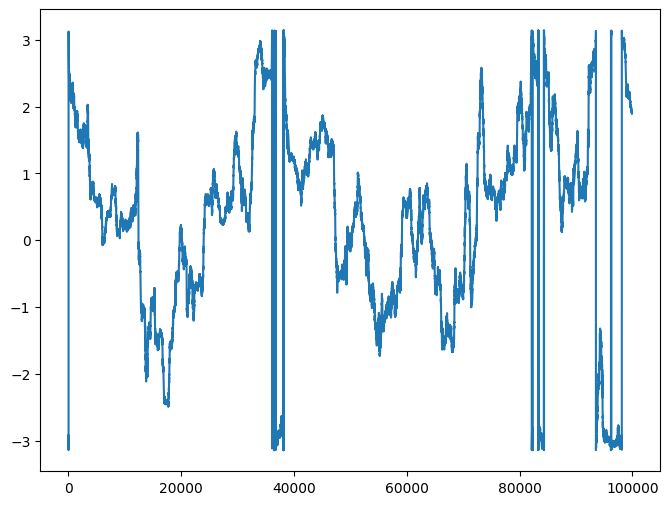

In [69]:
 #plot bump_center
fig = plt.figure(figsize=(8, 6))
plt.plot(bump_center)

/var/folders/cc/s0ls8jsx21n4zc1_dv62hvyc0000gn/T/ipykernel_25291/1098054639.py:41: RuntimeWarning: Mean of empty slice.
  fr_i_binned = [fr_i[inds==i].mean() for i in range(1, len(bins))]
/Users/chutianhao/opt/anaconda3/envs/bp311/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


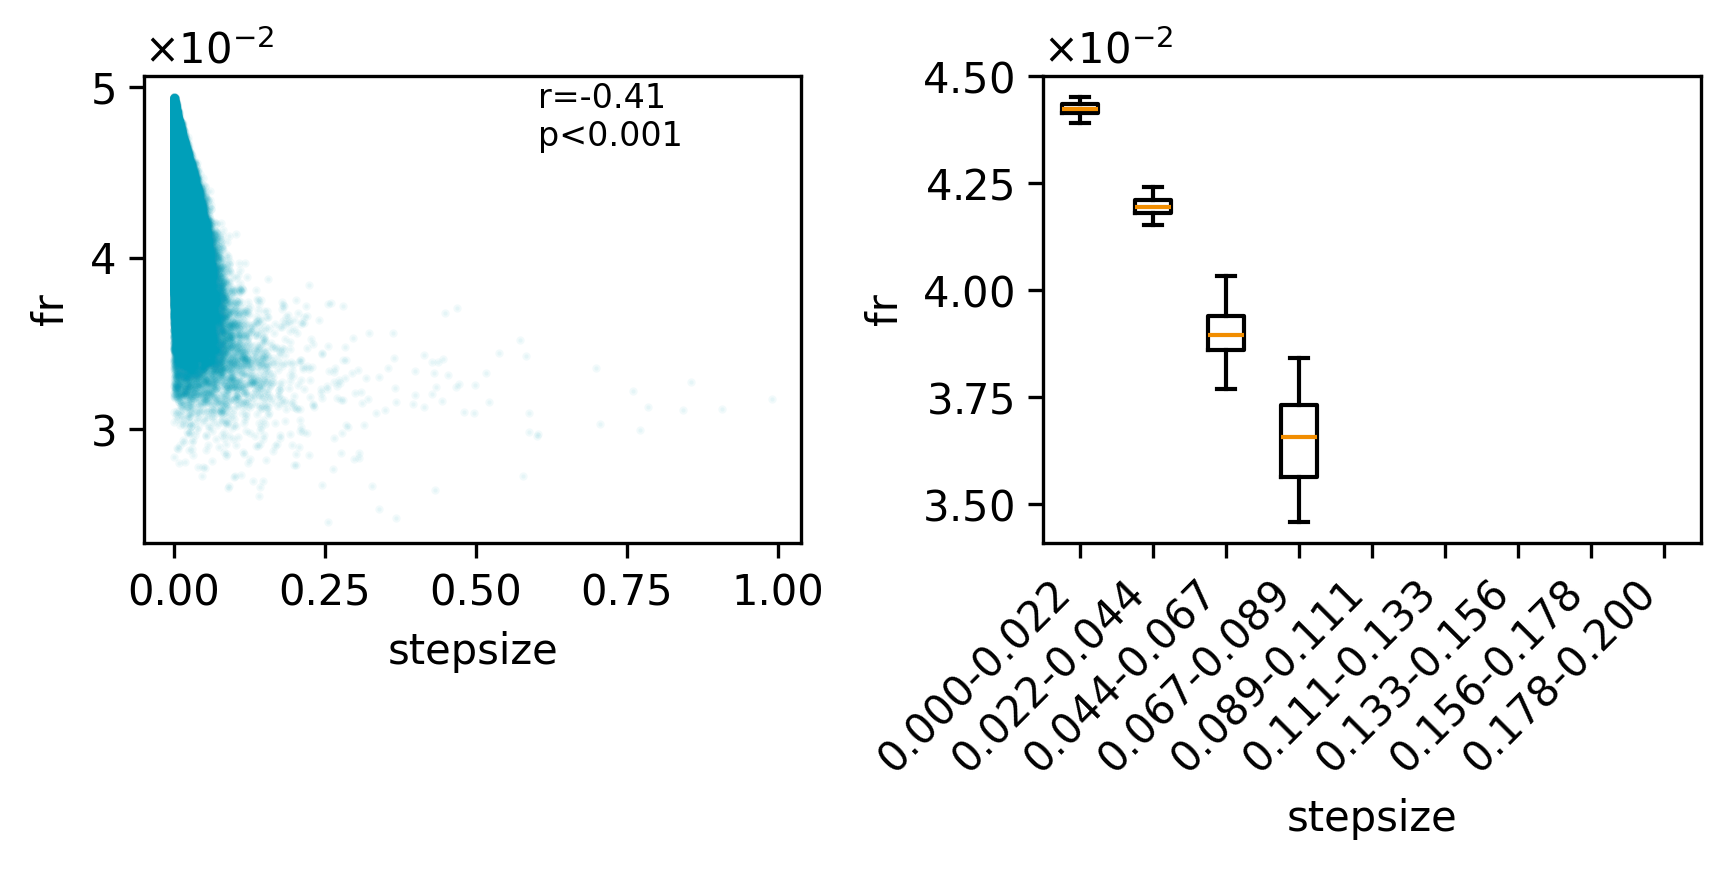

In [68]:

#scatter plot of stepsize and fr
fig = plt.figure(figsize=(6, 3), dpi=300)
gs = gridspec.GridSpec(1, 2)
labelsize = 10
ticksize = 8

ax1 = fig.add_subplot(gs[0, 0])

all_stepsize_list = np.concatenate(list(all_stepsize.values()))
all_fr_list = np.concatenate(list(all_fr.values())) 


ax1.scatter(all_stepsize_list, all_fr_list, s=1, c='#009FB9', alpha=0.05)
ax1.set_xlabel('stepsize')
ax1.set_ylabel('fr')

#pearson correlation of new_stepsize and new_fr
r, p = scipy.stats.pearsonr(all_stepsize_list, all_fr_list)
if p<0.001:
    ax1.text(0.6, 0.85, f'r={r:.2f}\np<0.001', transform=plt.gca().transAxes, fontsize=ticksize)
else:
    ax1.text(0.6, 0.85, f'r={r:.2f}\np={p:.3f}', transform=plt.gca().transAxes, fontsize=ticksize)
    
ax1.tick_params(axis='both', which='major', labelsize=labelsize)
#yticks in scientific notation
ax1.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useMathText=True)


#bin the step size and get the mean fr in each binned stepsize
#this will make the negtive correlation more obvious
ax2 = fig.add_subplot(gs[0, 1])
# max_stepsize = np.max(all_stepsize_list)
max_stepsize = 0.2
all_fr_binned = {}
for key in all_stepsize.keys():
    stepsize_i = all_stepsize[key]
    fr_i = all_fr[key]
    
    bins  = np.linspace(0, max_stepsize, 10)
    inds = np.digitize(stepsize_i, bins)
    fr_i_binned = [fr_i[inds==i].mean() for i in range(1, len(bins))]

    all_fr_binned[key] = fr_i_binned
    
#chaneg the dictionary to array
all_fr_binned = np.array(list(all_fr_binned.values()))

ax2.boxplot(all_fr_binned, showmeans=True, meanline=True, showfliers=False, 
            flierprops=dict(markersize=3), 
            meanprops=dict(color='#F18D00', linestyle='-', linewidth=1), 
            medianprops=dict(color='#009FB9', alpha=0))

ax2.set_xlabel('stepsize')
ax2.set_ylabel('fr')

#set the xlabels for each bin using values in bins, leep one decimal
# ax2.set_xticklabels([f'{bins[i]}-{bins[i+1]}' for i in range(0, len(bins)-1)], rotation=45, ha='right')
ax2.set_xticklabels([f'{bins[i]:.3f}-{bins[i+1]:.3f}' for i in range(0, len(bins)-1)], rotation=45, ha='right')

#ylabel in scientific notation
ax2.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useMathText=True)

plt.tight_layout()
    